<a href="https://colab.research.google.com/github/Kgsanderson93/AirportDelay/blob/main/591proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.1.0
!pip install torch_geometric
!pip install haversine
!pip install torch-geometric-temporal

import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 780.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86722 sha256=b4335cba799a07ccf1464b0d288e351074a0803b29015a0c7fd00caffe2d7ceb
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c


In [ ]:
from torch_geometric.data import Dataset
import numpy as np
import pandas as pd
import haversine as hs

df=pd.read_csv('/content/On_Time_Reporting_January_2023.csv')
airports_sub = pd.read_csv('/content/us-airports.csv')

In [ ]:
class Position:
    def __init__(self, longitude, latitude, altitude):
        self.longitude = longitude
        self.latitude = latitude
        self.altitude = altitude

    def get_longitude(self):
      return self.longitude

    def get_latitude(self):
      return self.latitude

    def get_altitude(self):
      return self.altitude

import datetime as dt
from datetime import datetime



import math
def find_T_Group(date):
    initial = datetime(year = 2023, month = 1, day = 1, hour = 0, minute = 0, second = 0)
    conv_time = pd.Timestamp.to_pydatetime(date)
    delta = conv_time - initial
    grouping = math.floor(math.floor(delta.total_seconds() / 60) / 15)
    return grouping

# New Section

In [ ]:
airports_sub = airports_sub[airports_sub["type"].isin(["large_airport", "medium_airport"])]

airports_sub = airports_sub[(airports_sub["name"].str.contains("Base") == False) |
                                    ((airports_sub["name"].str.contains("Base") == True) &
                                     (airports_sub["name"].str.contains("/") == True))]

airports_sub = airports_sub[(airports_sub["name"].str.contains("Landing") == False)]

airports_sub = airports_sub[(airports_sub["name"].str.contains("Airfield") == False) |
                    ((airports_sub["name"].str.contains("Airfield") == True) &
                    (airports_sub["name"].str.contains("Regional") == True))]

airports_sub = airports_sub[(airports_sub["name"].str.contains("Naval") == False)]

airports_sub = airports_sub[(airports_sub["name"].str.contains("Miramar") == False)]

airports_sub = airports_sub[(airports_sub["ident"].str.contains("US-") == False) |
                    (airports_sub["ident"].str.contains("US-0571") == True)]

airports_sub = airports_sub[(airports_sub["name"].str.contains("LRRS") == False)]

airport_list = airports_sub[["iata_code", "latitude_deg", "longitude_deg", "elevation_ft"]]
airport_list["index"] = airport_list.reset_index().index
airport_list = airport_list[["index", "iata_code", "latitude_deg", "longitude_deg", "elevation_ft"]]
airport_list = airport_list.rename(columns = {"iata_code" : "ident"})

airport_list.head()

<ipython-input-4-b0bcc634ea37>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_list["index"] = airport_list.reset_index().index


,index,ident,latitude_deg,longitude_deg,elevation_ft
0,0,LAX,33.942501,-118.407997,125.0
1,1,ORD,41.978600,-87.904800,672.0
2,2,JFK,40.639447,-73.779317,13.0
3,3,ATL,33.636700,-84.428101,1026.0
4,4,SFO,37.618999,-122.375000,13.0


In [ ]:
airport_dictionary = {}
airport_indexes = {}
airport_reverse_indexes = {}

for index, row in airport_list.iterrows():
  pos = Position(row["longitude_deg"], row["latitude_deg"], row["elevation_ft"])
  airport_dictionary.update({row["ident"] : pos})
  airport_indexes.update({row["ident"] : row["index"]})

for air_ident in airport_indexes:
  airport_reverse_indexes.update({airport_indexes.get(air_ident) : air_ident})

In [ ]:
air_zone=pd.read_csv("/content/optd_por_public_modded.csv")
clean_airports=airport_list.dropna()
airport_w_time=clean_airports.merge(air_zone, how="left")


In [ ]:
airport_w_time=airport_w_time[airport_w_time["ident"].notna()]
airport_w_time=airport_w_time.drop_duplicates(subset="ident", keep="first")
check=airport_w_time['ident']
df=df[(df["ORIGIN"].isin(check))]
df=df[(df["DEST"].isin(check))]

In [ ]:
t=clean_airports['ident'].isin(airport_w_time['ident']).value_counts()

#if t[0] != clean_airports.shape[0]:
  #raise Exception("Wrong final num of airports")

In [ ]:
def combine_date_time(date, military_time, zone_offset):

    ##Here we could add a check for DST
    zone_offset=dt.timedelta(minutes = int(zone_offset*60))
    str_date = datetime.strptime(date, '%m/%d/%Y %I:%M:%S %p')
    hours, minutes = divmod(military_time, 100)
    mil_time_minutes = 60*hours + minutes

    time_change = dt.timedelta(minutes = int(mil_time_minutes))
    corrected_time = str_date + time_change+zone_offset
    return corrected_time

In [ ]:
zone_dictionary={}
for index, row in airport_w_time.iterrows():
  zone_dictionary.update({row["ident"] : row["gmt_offset"]})
df["origin_offset"]=df.apply(lambda x: zone_dictionary.get(x["ORIGIN"]), axis=1)
df["dest_offset"]=df.apply(lambda x: zone_dictionary.get(x["DEST"]), axis=1)

In [ ]:
def cancellation_dep_time_conv(cancelled, crs_dep_time, dep_time):
  if (cancelled == 1):
    # At future time, try adjusting T_Group to 3 hours ahead
    # return crs_dep_time + 300
    return crs_dep_time
  return dep_time

df["DEP_TIME"] = df.apply(lambda x: cancellation_dep_time_conv(x['CANCELLED'], x['CRS_DEP_TIME'], x['DEP_TIME']), axis = 1)

df=df.dropna(subset=['DEP_TIME'])
df=df.dropna(subset=['ARR_TIME'])
df["corrected_Dep"] = df.apply(lambda x: combine_date_time(x['FL_DATE'], x['DEP_TIME'], x['origin_offset']), axis=1)
df["corrected_Arr"] = df.apply(lambda x: combine_date_time(x['FL_DATE'], x['ARR_TIME'], x['dest_offset']), axis=1)

df=df.drop(['FL_DATE', 'DEP_TIME', 'ARR_TIME'], axis=1)
df=df.sort_values(by='corrected_Dep')
df.reset_index(drop=True, inplace=True)
df["T_Group"] = df.apply(lambda x: find_T_Group(x['corrected_Dep']), axis=1)

Nodes=airports
edges = flights
node features= avg delay, position,
node label = avg flight delay at t







In [ ]:
df = df.sort_values(by=['T_Group', 'ORIGIN'])
df=df[(df["T_Group"]>=0)]
df


,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,...,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_ARR_DELAY,origin_offset,dest_offset,corrected_Dep,corrected_Arr,T_Group
958,DL,10140,ABQ,10397,ATL,710,-10.0,1209,-9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-7.0,-5.0,2023-01-01 00:00:00,2023-01-01 07:00:00,0
1059,WN,10140,ABQ,11292,DEN,525,106.0,655,81.0,0.0,...,0.0,0.0,0.0,0.0,NaN,-7.0,-7.0,2023-01-01 00:11:00,2023-01-01 01:16:00,0
1079,F9,10397,ATL,11298,DFW,505,7.0,639,-12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-5.0,-6.0,2023-01-01 00:12:00,2023-01-01 00:27:00,0
1005,AA,10423,AUS,13204,MCO,616,-12.0,944,-2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-6.0,-5.0,2023-01-01 00:04:00,2023-01-01 04:42:00,0
1020,AA,10423,AUS,15304,TPA,615,-10.0,930,-20.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-6.0,-5.0,2023-01-01 00:05:00,2023-01-01 04:10:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515121,F9,15304,TPA,12889,LAS,2248,54.0,101,40.0,0.0,...,0.0,0.0,0.0,40.0,NaN,-5.0,-8.0,2023-01-31 18:42:00,2023-01-30 17:41:00,2954
515124,DL,10721,BOS,14576,ROC,2215,100.0,2359,97.0,0.0,...,0.0,0.0,0.0,97.0,NaN,-5.0,-5.0,2023-01-31 18:55:00,2023-01-30 20:36:00,2955
515125,F9,12339,IND,12889,LAS,2336,21.0,59,21.0,0.0,...,0.0,0.0,0.0,0.0,NaN,-5.0,-8.0,2023-01-31 18:57:00,2023-01-30 17:20:00,2955
515123,NK,13303,MIA,12953,LGA,1600,466.0,1903,453.0,0.0,...,0.0,1.0,0.0,228.0,NaN,-5.0,-5.0,2023-01-31 18:46:00,2023-01-30 21:36:00,2955


In [ ]:
df.columns

Index(['OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID',
       'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'DIV_ARR_DELAY', 'origin_offset', 'dest_offset',
       'corrected_Dep', 'corrected_Arr', 'T_Group'],
      dtype='object')

In [ ]:
# Converting negative dep delays to 0. This was a function that we were interested in changing farther along given the time to do so
def convert_negative_dep_times(time, cancelled):
  if (cancelled == 1.0):
    return 180
  if (time < 0):
    return 0
  return time

df["DEP_DELAY"] = df.apply(lambda x: convert_negative_dep_times(x['DEP_DELAY'], x['CANCELLED']), axis=1)

In [ ]:
### Output for group_by actions is a Pandas Series

## To find average delay at time T for each node

## Change to the Origin ID later, I used ORIGIN because it's easier to distinguish intended functionality

# All values should have a 1 to 1 relationship between airport_T_group_delays and airport_T_group_num_flights
# For the delay at each airport at time T
aggregated_origin = df.groupby(["T_Group","ORIGIN"])
airport_T_group_delays = aggregated_origin["DEP_DELAY"].sum().reset_index().rename(columns = {"DEP_DELAY" : "CUM_DELAY"})

# For collecting the number of flights that took off from each airport
T_grouping = df.groupby(["T_Group"])
airport_T_group_num_flights = T_grouping["ORIGIN"].value_counts(sort = False)
airport_T_group_num_flights = airport_T_group_num_flights.to_frame().rename(columns = {"ORIGIN" : "COUNT"}).reset_index()
airport_T_group_num_flights = airport_T_group_num_flights.rename(columns = {"ORIGIN" : "ORIGINb", "T_Group" : "T_Groupb"})

combined = pd.concat([airport_T_group_delays, airport_T_group_num_flights], axis = 1)
combined = combined[["T_Group", "ORIGIN", "CUM_DELAY", "COUNT"]]

# Calculating the Average Delay for a node within a T_Group
combined["AVG_DELAY"] = combined["CUM_DELAY"] / combined["COUNT"]

## This can be done in one function and one line with a function called zip, but I'm struggling to put it together
## properly
def get_long(origin):
  pos = airport_dictionary.get(origin)
  if (pos is None):
    return None
  return pos.get_longitude()

def get_lat(origin):
  pos = airport_dictionary.get(origin)
  if (pos is None):
    return None
  return pos.get_latitude()

def get_alt(origin):
  pos = airport_dictionary.get(origin)
  if (pos is None):
    return None
  return pos.get_altitude()

# Adding the position data via the Dictionary
combined["LONGITUDE"] = combined.apply(lambda x: get_long(x['ORIGIN']), axis=1)
combined["LATITUDE"] = combined.apply(lambda x: get_lat(x['ORIGIN']), axis=1)
combined["ALTITUDE"] = combined.apply(lambda x: get_alt(x['ORIGIN']), axis=1)

# To calculate distance between airports
def calc_distance(origin, destination):
  pos1 = airport_dictionary.get(origin)
  pos2 = airport_dictionary.get(destination)

  if (pos1 is None or pos2 is None):
    return None
  loc1 = (pos1.get_latitude(), pos1.get_longitude())
  loc2 = (pos2.get_latitude(), pos2.get_longitude())
  return hs.haversine(loc1, loc2) * 0.621371

# Subsetting to remove locations with null position data. It's technically safer to check all three, but because of the way
# our airport data set was structured, if one is missing, then they're all missing. So we can be a tiny bit more efficient
# by checking against just one column.
combined = combined[(combined["ALTITUDE"].isnull() == False)]
# combined = combined[(combined["LONGITUDE"].isnull() == False)]
# combined = combined[(combined["LATITUDE"].isnull() == False)]

# Attaches an id to the airport. I sort of cheat here and use an index tab where I know there's a 1 - 1 relationship.
# It appears that all airport numeric IDs in each data set are arbitrary anyways which is interesting.
def get_index_id(origin):
  ind = airport_indexes.get(origin)
  if (ind is None):
    return None
  return ind

combined["AIR_ID"] = combined.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)

combined = combined[(combined["AIR_ID"].isnull() == False)]

combined = combined[["T_Group", "AIR_ID", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
# This should be very close to the structure of the x input after we convert to a torch tensor. Need to do another
# group_by when every thing is collected.


In [ ]:
### Edge definition
rho = 165.0
reduced_df = df[["T_Group", "ORIGIN", "DEST", "DISTANCE"]]

# The numbers won't be exact, but they should be close. Need to investigate why some values are very very different
reduced_df["N_DISTANCE"] = reduced_df.apply(lambda x: calc_distance(x['ORIGIN'], x['DEST']), axis = 1)

# Use this to identify number of duplicate routes within a T_Group
reduced_df["ROUTE"] = reduced_df["ORIGIN"] + "-" + reduced_df["DEST"]

reduced_df

<ipython-input-16-13988c51dbbb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["N_DISTANCE"] = reduced_df.apply(lambda x: calc_distance(x['ORIGIN'], x['DEST']), axis = 1)
<ipython-input-16-13988c51dbbb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["ROUTE"] = reduced_df["ORIGIN"] + "-" + reduced_df["DEST"]


,T_Group,ORIGIN,DEST,DISTANCE,N_DISTANCE,ROUTE
958,0,ABQ,ATL,1269.0,1266.562948,ABQ-ATL
1059,0,ABQ,DEN,349.0,349.622964,ABQ-DEN
1079,0,ATL,DFW,731.0,729.821022,ATL-DFW
1005,0,AUS,MCO,994.0,991.878037,AUS-MCO
1020,0,AUS,TPA,928.0,925.555787,AUS-TPA
...,...,...,...,...,...,...
515121,2954,TPA,LAS,1984.0,1980.610150,TPA-LAS
515124,2955,BOS,ROC,343.0,342.216700,BOS-ROC
515125,2955,IND,LAS,1590.0,1586.196472,IND-LAS
515123,2955,MIA,LGA,1096.0,1098.819914,MIA-LGA


In [ ]:
airports=[]
for airport in reduced_df["ORIGIN"]:
  if airport not in airports:
    airports.append(airport)

for airport in reduced_df["DEST"]:
  if airport not in airports:
    airports.append(airport)

rownum=785
colnum=785
adjacency_matrix = np.zeros((rownum, colnum), dtype=int)

adjacency_matrix.size

for key1 in airport_dictionary:
  for key2 in airport_dictionary:
      distance=calc_distance(key1, key2)
      if distance<rho:
        adjacency_matrix[airport_indexes.get(key1)][airport_indexes.get(key2)]=1
        adjacency_matrix[airport_indexes.get(key2)][airport_indexes.get(key1)]=1

In [ ]:
### Edge Embedding
def get_origin_from_route(route):
  return route[0:3]

def get_dest_from_route(route):
  return route[4:]

edge_grouping = reduced_df.groupby(["T_Group"])["ROUTE"].value_counts().to_frame().rename(columns = {"ROUTE" : "COUNT"}).reset_index()
edge_grouping["ORIGIN"] = edge_grouping.apply(lambda x: get_origin_from_route(x['ROUTE']), axis = 1)
edge_grouping["DEST"] = edge_grouping.apply(lambda x: get_dest_from_route(x['ROUTE']), axis = 1)

edge_grouping["ORIGIN_ID"] = edge_grouping.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
edge_grouping["DEST_ID"] = edge_grouping.apply(lambda x: get_index_id(x['DEST']), axis = 1)

edge_grouping = edge_grouping.sort_values(by = ["T_Group", "ORIGIN_ID", "DEST_ID"])

edge_grouping["DISTANCE"] = edge_grouping.apply(lambda x: calc_distance(x['ORIGIN'], x['DEST']), axis = 1)
edge_grouping = edge_grouping[["T_Group", "COUNT", "DISTANCE"]]

# Now need to encode Route and this should(?) function as edge embedding input
edge_grouping

,T_Group,COUNT,DISTANCE
69,0,1,337.522539
64,0,1,236.263867
68,0,1,955.026825
65,0,1,369.659124
0,0,2,2605.430285
...,...,...,...
499922,2954,1,1055.564645
499926,2955,1,1098.819914
499924,2955,1,342.216700
499925,2955,1,1586.196472


In [ ]:
reduced_df["ORIGIN_ID"] = reduced_df.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
reduced_df["DEST_ID"] = reduced_df.apply(lambda x: get_index_id(x['DEST']), axis = 1)

reduced_df = reduced_df.sort_values(by = ["T_Group", "ORIGIN_ID", "DEST_ID"])
reduced_df

<ipython-input-19-87ca3aac2562>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["ORIGIN_ID"] = reduced_df.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
<ipython-input-19-87ca3aac2562>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["DEST_ID"] = reduced_df.apply(lambda x: get_index_id(x['DEST']), axis = 1)


,T_Group,ORIGIN,DEST,DISTANCE,N_DISTANCE,ROUTE,ORIGIN_ID,DEST_ID
1102,0,LAX,SFO,337.0,337.522539,LAX-SFO,0,4
1043,0,LAX,LAS,236.0,236.263867,LAX-LAS,0,7
1090,0,LAX,SEA,954.0,955.026825,LAX-SEA,0,13
1058,0,LAX,PHX,370.0,369.659124,LAX-PHX,0,14
1084,0,LAX,BOS,2611.0,2605.430285,LAX-BOS,0,15
...,...,...,...,...,...,...,...,...
515115,2954,TPA,BUF,1053.0,1055.564645,TPA-BUF,31,53
515123,2955,MIA,LGA,1096.0,1098.819914,MIA-LGA,12,11
515124,2955,BOS,ROC,343.0,342.216700,BOS-ROC,15,79
515125,2955,IND,LAS,1590.0,1586.196472,IND-LAS,45,7


In [ ]:
empty_df = pd.DataFrame(columns = ["AIR_ID", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"])

for aport in airport_dictionary.keys():
  empty_airport = {"AIR_ID": np.int64(airport_indexes.get(aport)), "AVG_DELAY" : 0.000000, "LONGITUDE" : get_long(aport),
                   "LATITUDE" : get_lat(aport), "ALTITUDE" : get_alt(aport)}
  empty_data = pd.DataFrame([empty_airport])
  empty_df = pd.concat([empty_df, empty_data], axis = 0, ignore_index = True)

empty_df

,AIR_ID,AVG_DELAY,LONGITUDE,LATITUDE,ALTITUDE
0,0,0.0,-118.407997,33.942501,125.0
1,1,0.0,-87.904800,41.978600,672.0
2,2,0.0,-73.779317,40.639447,13.0
3,3,0.0,-84.428101,33.636700,1026.0
4,4,0.0,-122.375000,37.618999,13.0
...,...,...,...,...,...
749,780,0.0,-116.629997,35.280499,2350.0
750,781,0.0,-93.191704,31.044800,330.0
751,782,0.0,-164.563004,67.736198,13.0
752,783,0.0,-155.470001,64.727203,658.0


In [ ]:
a_list = empty_df['AIR_ID']
a_list

0        0
1        1
2        2
3        3
4        4
      ... 
749    780
750    781
751    782
752    783
753    784
Name: AIR_ID, Length: 754, dtype: object

T1
Nodes
edges



In [ ]:
### For Operational Graph
pd.options.mode.chained_assignment = None
### Not the cleanest approach, I think we'd want to take a group_by object and then convert to a series
### for cleanliness, but this appears to work correctly.

# Finds the last T_Group -> Using this to iterate through the T_Group indexes so that we can subset more easily
last_t_group = reduced_df["T_Group"][len(reduced_df) - 1] - 1

data_list = []
xs = []
edge_indices = []
edge_attributes = []
ys = []
out_y_indices = []

empty_count = 0
def fill_na(check):
  if (np.isnan(check) == True):
    return 0
  return check

def remove_common(a, b):
  a = [i for i in a if i not in b]

# Loops through all T_Groups
for n in range(last_t_group + 1):
# for n in range(1):
  ## Setting up the node data frame
  # Gets the combined node data for the given T Group
  base_node = combined[combined["T_Group"] == n]

  # Re-orders the data so that airport ID is first
  base_node = base_node[["AIR_ID", "T_Group", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"]]

  # From here we want to pad, such that every airport not currently in the node list is added and given default zeroes
  listx = base_node['AIR_ID']

  t_empty_df = empty_df[empty_df["AIR_ID"].isin(listx) == False]
  t_empty_df["T_Group"] = n
  t_empty_df = t_empty_df[["AIR_ID", "T_Group", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
  t_empty_df["AIR_ID"] = np.int64(t_empty_df["AIR_ID"])

  base_node = pd.concat([base_node, t_empty_df], axis = 0, ignore_index = True)

  # Setting up the time lag
  # Shape is now correct, now figuring out order
  next_node = combined[combined["T_Group"] == n + 1]
  next_node = next_node[["AIR_ID", "AVG_DELAY"]]

  next_index_order_alt = base_node["AIR_ID"]
  # next_index_order = next_node["AIR_ID"]

  listy = next_node["AIR_ID"]
  # list_alt = remove_common(a_list.to_list(), listy.to_list())
  # altl = pd.DataFrame()
  # next_index_order = next_index_order + list_alt

  next_node = next_node[["AVG_DELAY"]]

  y_t_empty_df = empty_df[empty_df["AIR_ID"].isin(listy) == False]
  y_t_empty_df = y_t_empty_df[["AVG_DELAY"]]

  next_node = pd.concat([next_node, y_t_empty_df], axis = 0, ignore_index = True)
  next_node = next_node.reindex(index = next_index_order_alt)

  next_node["AVG_DELAY"] = next_node.apply(lambda x: fill_na(x['AVG_DELAY']), axis = 1)

  holder = next_node["AVG_DELAY"]

  next_index_order = next_node
  next_index_order = next_index_order.reset_index()
  next_index_order = next_index_order["AIR_ID"]

  n_i_holder = pd.DataFrame(next_index_order)

  ## Setting up the edge list
  # Gets the edge data for the given T Group
  base_edge = reduced_df[reduced_df["T_Group"] == n]

  if (base_edge.empty == False):
    # Attaches the Origin and Destination IDs to this edge list
    # base_edge["ORIGIN_ID"] = base_edge.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
    # base_edge["DEST_ID"] = base_edge.apply(lambda x: get_index_id(x['DEST']), axis = 1)

    # Removes NA edges (Caused by airports not in our data set)
    base_edge = base_edge.dropna(subset=['ORIGIN_ID'])
    base_edge = base_edge.dropna(subset=['DEST_ID'])

    # Subsets columns to just origin and destination IDs
    base_edge = base_edge[["ORIGIN_ID", "DEST_ID"]]

    base_edge = base_edge.drop_duplicates(keep='first')

    # base_edge

    ### Setting up the edge embedding data frame
    # Gets the edge embedding data for the given T Group
    base_edge_embedding = edge_grouping[edge_grouping["T_Group"] == n]

    # Removes edge embeddings for NA distances -> Caused by the same thing as the NA origin / destination IDs
    base_edge_embedding = base_edge_embedding.dropna(subset=['DISTANCE'])

    # Subsets columns to just the flight count and distance traveled
    base_edge_embedding = base_edge_embedding[["DISTANCE"]]

    # reduced_df[reduced_df["T_Group"] == n]

    try:
      # Converts the three pieces of data into numpy data frames
      # base_x = torch.tensor(base_node.to_numpy(), dtype=torch.float64)
      # base_edge_index = torch.tensor(base_edge.to_numpy().T, dtype=torch.float64)
      # base_edge_embeddings = torch.tensor(base_edge_embedding.to_numpy(), dtype=torch.float64)
      # base_y = torch.tensor(next_node.to_numpy(), dtype=torch.float64)

      base_x = base_node.to_numpy()
      base_edge_index = base_edge.to_numpy().T
      base_edge_embeddings = base_edge_embedding.to_numpy()
      base_y = holder.to_numpy()
      base_y_indices = n_i_holder.to_numpy().T

      xs.append(base_x)
      edge_indices.append(base_edge_index)
      edge_attributes.append(base_edge_embeddings)
      ys.append(base_y)
      out_y_indices.append(base_y_indices)

      # Creates a Data object using the converted three pieces of graph data
      # data_base = Data(x = base_x, edge_index = base_edge_index, edge_attr = base_edge_embedding)

      # Appends the Data object to the list of all Data objects
      # data_list.append(data_base)
    except:
      empty_count = empty_count + 1

In [ ]:
for i in range(0,10):
  print (i,"frame")
  print(xs[i].shape)
  print(edge_indices[i].shape)
  print(edge_attributes[i].shape)
  print(ys[i].shape)
  print(out_y_indices[i].shape)

0 frame
(754, 6)
(2, 146)
(146, 1)
(754,)
(1, 754)
1 frame
(754, 6)
(2, 123)
(123, 1)
(754,)
(1, 754)
2 frame
(754, 6)
(2, 125)
(125, 1)
(754,)
(1, 754)
3 frame
(754, 6)
(2, 234)
(234, 1)
(754,)
(1, 754)
4 frame
(754, 6)
(2, 250)
(250, 1)
(754,)
(1, 754)
5 frame
(754, 6)
(2, 188)
(188, 1)
(754,)
(1, 754)
6 frame
(754, 6)
(2, 144)
(144, 1)
(754,)
(1, 754)
7 frame
(754, 6)
(2, 190)
(190, 1)
(754,)
(1, 754)
8 frame
(754, 6)
(2, 209)
(209, 1)
(754,)
(1, 754)
9 frame
(754, 6)
(2, 175)
(175, 1)
(754,)
(1, 754)


In [ ]:
pd.options.mode.chained_assignment = "warn"
operational_loader = DataLoader(data_list, batch_size=32)

operational_loader

In [ ]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

In [ ]:
operational_dataset = DynamicGraphTemporalSignal(edge_indices, edge_attributes, xs, ys, y_indices = out_y_indices)

In [ ]:
train_dataset, test_dataset = temporal_signal_split(operational_dataset, train_ratio=0.2)

In [ ]:
import torch.nn as nn
from torch_geometric_temporal.nn.recurrent import TGCN

In [ ]:
class TemporalGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalGCN, self).__init__()

        self.conv1 = TGCN(input_dim, hidden_dim)
        self.conv2 = TGCN(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        return x

In [ ]:
input_dim = 6 #Lat, #Long, #alt TGroup, ID, AVG DElay
hidden_dim = 2
output_dim =2

model = TemporalGCN(input_dim, hidden_dim, output_dim)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  i=0
  for snapshot in train_dataset:
    optimizer.zero_grad()
    print(i)
    i=i+1
    print(snapshot.x.shape)
    print(snapshot.edge_index.shape)
    print(snapshot.edge_attr.shape)
    output = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    output = output.view(-1)
    loss = criterion(output, snapshot.y.view(-1, 1))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  average_loss = total_loss / len(train_dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_loss:.4f}")


0
torch.Size([754, 6])
torch.Size([2, 146])
torch.Size([146, 1])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([754, 1])) that is different to the input size (torch.Size([1508])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
torch.Size([754, 6])
torch.Size([2, 123])
torch.Size([123, 1])
2
torch.Size([754, 6])
torch.Size([2, 125])
torch.Size([125, 1])
3
torch.Size([754, 6])
torch.Size([2, 234])
torch.Size([234, 1])
4
torch.Size([754, 6])
torch.Size([2, 250])
torch.Size([250, 1])
5
torch.Size([754, 6])
torch.Size([2, 188])
torch.Size([188, 1])
6
torch.Size([754, 6])
torch.Size([2, 144])
torch.Size([144, 1])
7
torch.Size([754, 6])
torch.Size([2, 190])
torch.Size([190, 1])
8
torch.Size([754, 6])
torch.Size([2, 209])
torch.Size([209, 1])
9
torch.Size([754, 6])
torch.Size([2, 175])
torch.Size([175, 1])
10
torch.Size([754, 6])
torch.Size([2, 177])
torch.Size([177, 1])
11
torch.Size([754, 6])
torch.Size([2, 252])
torch.Size([252, 1])
12
torch.Size([754, 6])
torch.Size([2, 208])
torch.Size([208, 1])
13
torch.Size([754, 6])
torch.Size([2, 242])
torch.Size([242, 1])
14
torch.Size([754, 6])
torch.Size([2, 187])
torch.Size([187, 1])
15
torch.Size([754, 6])
torch.Size([2, 235])
torch.Size([235, 1])
16
torch.Size([754,

TypeError: ignored

In [ ]:
from tqdm import tqdm

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
operational_dataset

In [ ]:
model = RecurrentGCN(node_features = 6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

In [ ]:
# Creating a base frame for the edge list

test_geo_unconn_frame = pd.DataFrame(columns=["ORIGIN", "DEST", "O-D", "D-O"])

for w in range(785 - 1):
  for q in range(w + 1, 785):
    if (adjacency_matrix[w][q] == 1):
      cat1 = str(w) + "-" + str(q)
      cat2 = str(q) + "-" + str(w)
      new_row = {"ORIGIN" : w, "DEST" : q, "O-D" : cat1, "D-O" : cat2}
      test_row_construction = pd.DataFrame([new_row])
      test_geo_unconn_frame = pd.concat([test_geo_unconn_frame, test_row_construction], axis = 0, ignore_index = True)

test_node_res = pd.concat([airport_T_group_delays, airport_T_group_num_flights], axis = 1)
test_node_res = test_node_res[["T_Group", "ORIGIN", "COUNT"]]

In [ ]:
pd.options.mode.chained_assignment = None

### For both geographic graphs

# This gets the edges with routes
test_edge_sub = reduced_df[reduced_df["T_Group"] == 78]
test_edge_sub = test_edge_sub.dropna(subset=['N_DISTANCE'])
test_flight_edges = test_edge_sub[test_edge_sub["N_DISTANCE"] < rho]







# Finds all airports connected to the edges with routes
test_unique_origin = test_flight_edges.ORIGIN.unique()
test_unique_dest = test_flight_edges.DEST.unique()

# Creates a dictionary for connected nodes
test_connected_nodes = {}

# Adds unique origin airports
for origin_item in test_unique_origin:
  test_connected_nodes.update({airport_indexes.get(origin_item) : 1})

# Adds unique destination airports
for dest_item in test_unique_dest:
  test_connected_nodes.update({airport_indexes.get(dest_item) : 1})

test_geo_conn_keylist = test_connected_nodes.keys()

# Sets up the edge embeddings for the geo graph with flights between airports
test_geo_conn_edge_embeddings = test_flight_edges[["N_DISTANCE"]]
test_geo_conn_edge_embeddings = test_geo_conn_edge_embeddings.rename(columns = {"N_DISTANCE" : "DISTANCE"})

# Sets up the edges for the geo graph with flights between airports
test_flight_edges["ORIGIN_ID"] = test_flight_edges.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
test_flight_edges["DEST_ID"] = test_flight_edges.apply(lambda x: get_index_id(x['DEST']), axis = 1)
test_flight_edges = test_flight_edges[["ORIGIN_ID", "DEST_ID"]]

# Sets up the nodes for the geo graph with flights between airports
test_geo_conn_nodes = combined[combined["T_Group"] == 78]
test_geo_conn_nodes = test_geo_conn_nodes[test_geo_conn_nodes["AIR_ID"].isin(test_geo_conn_keylist)]
test_geo_conn_nodes = test_geo_conn_nodes[["AIR_ID", "T_Group", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"]]

# Want to pad here

# Finds missing nodes (AKA destinations without a current outgoing flight)
test_diff_set = test_geo_conn_keylist - test_geo_conn_nodes.AIR_ID.to_list()

# Generates rows for the missing nodes
for node_diff in test_diff_set:
  new_node_ident = airport_reverse_indexes.get(node_diff)
  new_data = {"AIR_ID" : node_diff, "T_Group" : 78, "AVG_DELAY" : 0.000000, "LONGITUDE" : get_long(new_node_ident),
              "LATITUDE" : get_lat(new_node_ident), "ALTITUDE" : get_alt(new_node_ident)}
  new_df = pd.DataFrame([new_data])
  test_geo_conn_nodes = pd.concat([test_geo_conn_nodes, new_df], axis = 0, ignore_index = True)

# Creates the geo graph with flights between airports
conn_t_x = torch.tensor(test_geo_conn_nodes.to_numpy())
conn_t_edge_index = torch.tensor(test_flight_edges.to_numpy().T)
conn_t_edge_embeddings = torch.tensor(test_geo_conn_edge_embeddings.to_numpy())

# Creates a Data object using the converted three pieces of graph data
t_conn_geo_base = Data(x = conn_t_x, edge_index = conn_t_edge_index, edge_attr = conn_t_edge_embeddings)

In [ ]:
test_geo_conn_edge_embeddings

,DISTANCE
15367,159.624416
15384,163.462224


In [ ]:
# This is a lot more involved, but it gets around a really computationally expensive O(n^3) computation
def set_o_d(origin, destination):
  return str(origin) + "-" + str(destination)

def set_d_o(origin, destination):
  return str(destination) + "-" + str(origin)

# Creates unique identfier for routes as well as their reverse for the geo graph with connections because we'll need to subset
# those out from the data frame
test_comp_conn_edge = test_flight_edges
test_comp_conn_edge["OD"] = test_comp_conn_edge.apply(lambda x: set_o_d(x['ORIGIN_ID'], x['DEST_ID']), axis = 1)
test_comp_conn_edge["DO"] = test_comp_conn_edge.apply(lambda x: set_d_o(x['ORIGIN_ID'], x['DEST_ID']), axis = 1)

test_edge_comp_list = {}

test_unique_o_d = test_flight_edges.OD.unique()
test_unique_d_o = test_flight_edges.DO.unique()

for unique_o_d in test_unique_o_d:
  test_edge_comp_list.update({unique_o_d : 1})
for unique_d_o in test_unique_d_o:
  test_edge_comp_list.update({unique_d_o : 1})

test_edge_comps = test_edge_comp_list.keys()

# Subsets the current routes from this edge list
frame_list = test_geo_unconn_frame[(test_geo_unconn_frame["O-D"].isin(test_edge_comps) == True)]
# frame_list = frame_list[frame_list["D-O"].isin(test_edge_comps) == False]

test_node_unconn = test_node_res[test_node_res["T_Group"] == 78]
test_node_unconn["ORIGIN_ID"] = test_node_unconn.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
test_node_unconn = test_node_unconn[["ORIGIN_ID", "T_Group", "COUNT"]]

test_nodes_w_flights = test_node_unconn.ORIGIN_ID.to_list()



In [ ]:
df["T_Group"]

958          0
1059         0
1079         0
1005         0
1020         0
          ... 
515121    2954
515124    2955
515125    2955
515123    2955
515126    2956
Name: T_Group, Length: 514171, dtype: int64

##START

<Axes: xlabel='index', ylabel='flights_per_15'>

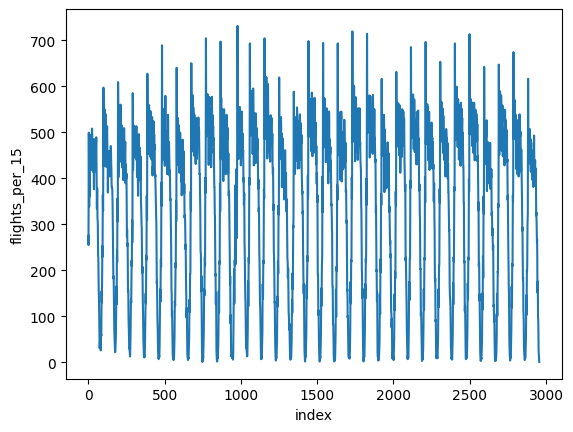

In [ ]:
import seaborn as sns
start_t=df["T_Group"].values.min()
end_t=df["T_Group"].values.max()
interval=1
bucket_elements=[]
while start_t<=end_t:
  bucket_elements.append(df[((start_t+interval) >= df["T_Group"])
                         & (start_t <= df["T_Group"])].shape[0])
  start_t+= interval

sns.lineplot(x="index", y="flights_per_15", data=pd.DataFrame(bucket_elements, columns=["flights_per_15"]).reset_index())

In [ ]:
airport_w_time=airport_w_time[airport_w_time["ident"].notna()]
airport_w_time=airport_w_time.drop_duplicates(subset="ident", keep="first")
check=airport_w_time['ident']
df=df[(df["ORIGIN"].isin(check))]
df=df[(df["DEST"].isin(check))]


In [ ]:
print(len(airports))
print(airport_w_time.ident.shape)


321
(753,)


In [ ]:
airport_w_time=airport_w_time.reset_index()


In [ ]:
airport_w_time=airport_w_time.drop(["level_0", "index"], axis=1 )


KeyError: ignored

In [ ]:
airport_w_time=airport_w_time.reset_index()

In [ ]:
airport_dictionary = {}
airport_indexes = {}
airport_reverse_indexes = {}

for index, row in airport_w_time.iterrows():
  print(index)
  print(row)
  pos = Position(row["longitude_deg"], row["latitude_deg"], row["elevation_ft"])
  airport_dictionary.update({row["ident"] : pos})
  airport_indexes.update({row["ident"] : row["index"]})

for air_ident in airport_indexes:
  airport_reverse_indexes.update({airport_indexes.get(air_ident) : air_ident})

Streaming output truncated to the last 5000 lines.
elevation_ft               668.0
timezone         America/Detroit
gmt_offset                  -5.0
dst_offset                  -4.0
raw_offset                  -5.0
Name: 298, dtype: object
299
index                         299
ident                         GFL
latitude_deg            43.341202
longitude_deg          -73.610298
elevation_ft                328.0
timezone         America/New_York
gmt_offset                   -5.0
dst_offset                   -4.0
raw_offset                   -5.0
Name: 299, dtype: object
300
index                            300
ident                            MER
latitude_deg               37.380501
longitude_deg            -120.568001
elevation_ft                   191.0
timezone         America/Los_Angeles
gmt_offset                      -8.0
dst_offset                      -7.0
raw_offset                      -8.0
Name: 300, dtype: object
301
index                        301
ident                    

In [ ]:
df

,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,...,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_ARR_DELAY,origin_offset,dest_offset,corrected_Dep,corrected_Arr,T_Group
958,DL,10140,ABQ,10397,ATL,710,0.0,1209,-9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-7.0,-5.0,2023-01-01 00:00:00,2023-01-01 07:00:00,0
1059,WN,10140,ABQ,11292,DEN,525,106.0,655,81.0,0.0,...,0.0,0.0,0.0,0.0,NaN,-7.0,-7.0,2023-01-01 00:11:00,2023-01-01 01:16:00,0
1079,F9,10397,ATL,11298,DFW,505,7.0,639,-12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-5.0,-6.0,2023-01-01 00:12:00,2023-01-01 00:27:00,0
1005,AA,10423,AUS,13204,MCO,616,0.0,944,-2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-6.0,-5.0,2023-01-01 00:04:00,2023-01-01 04:42:00,0
1020,AA,10423,AUS,15304,TPA,615,0.0,930,-20.0,0.0,...,NaN,NaN,NaN,NaN,NaN,-6.0,-5.0,2023-01-01 00:05:00,2023-01-01 04:10:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515121,F9,15304,TPA,12889,LAS,2248,54.0,101,40.0,0.0,...,0.0,0.0,0.0,40.0,NaN,-5.0,-8.0,2023-01-31 18:42:00,2023-01-30 17:41:00,2954
515124,DL,10721,BOS,14576,ROC,2215,100.0,2359,97.0,0.0,...,0.0,0.0,0.0,97.0,NaN,-5.0,-5.0,2023-01-31 18:55:00,2023-01-30 20:36:00,2955
515125,F9,12339,IND,12889,LAS,2336,21.0,59,21.0,0.0,...,0.0,0.0,0.0,0.0,NaN,-5.0,-8.0,2023-01-31 18:57:00,2023-01-30 17:20:00,2955
515123,NK,13303,MIA,12953,LGA,1600,466.0,1903,453.0,0.0,...,0.0,1.0,0.0,228.0,NaN,-5.0,-5.0,2023-01-31 18:46:00,2023-01-30 21:36:00,2955


In [ ]:
df["start_index"]=df.apply(lambda x:airport_indexes.get(x["ORIGIN"]), axis=1)
df["end_index"]=df.apply(lambda x:airport_indexes.get(x["DEST"]), axis=1)


In [ ]:
df

In [ ]:
df["distance"] = df.apply(lambda x: calc_distance(x["ORIGIN"], x["DEST"]),  axis=1)




In [ ]:
dftabmod=df[["T_Group", "start_index", "end_index", "distance", "corrected_Dep", "corrected_Arr", "ORIGIN", "DEST", "DEP_DELAY", "ARR_DELAY"]]

In [ ]:
start_w_time= airport_w_time.copy(deep=True)
end_w_time= airport_w_time.copy(deep=True)
start_w_time=start_w_time.rename(columns={"index":"start_index", "ident":"start_ident", "latitude_deg":"start_lat", "longitude_deg":"start_long", "elevation_ft": "start_elevation", "timezone":"start_zone", "gmt_offset":"start_offset"})


In [ ]:
end_w_time=end_w_time.rename(columns={"index":"end_index", "ident":"end_ident", "latitude_deg":"end_lat", "longitude_deg":"end_long", "elevation_ft": "end_elevation", "timezone":"end_zone", "gmt_offset":"end_offset"})

In [ ]:
all_starts= start_w_time
all_ends= end_w_time
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: calc_distance(x["start_ident"], x["end_ident"]),  axis=1)


In [ ]:
distance_matrix.shape

In [ ]:
distance_matrix.head()
distance_matrix["edge"] = distance_matrix["distance"] < rho

In [ ]:
distance_matrix

In [ ]:
distance_matrix.head()
edge_index_neighbor=distance_matrix[distance_matrix["edge"]==True][["start_index", "end_index"]].values
edge_index_neighbor = edge_index_neighbor.transpose()
edge_index_neighbor.shape

In [ ]:
dftabmod

In [ ]:
outgoing_trips=dftabmod.groupby("start_index").count()["DEP_DELAY"].values
incoming_trips=dftabmod.groupby("end_index").count()["ARR_DELAY"].values


# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features # [num_nodes x num_features]

In [ ]:
distance_matrix["edge"] = distance_matrix["distance"] < rho
distance_matrix.head()

In [ ]:
# Use mask to extract static edges
edge_index = distance_matrix[distance_matrix["edge"] == True][["start_index", "end_index"]].values
edge_index = edge_index.transpose()
edge_index.shape # [2 x num_edges]

In [ ]:
distance_feature = distance_matrix[distance_matrix["edge"] == True]["distance"].values
edge_type_feature = np.zeros_like(distance_feature) # 0 = static edge
trip_delay_feature = np.zeros_like(distance_feature)
static_edge_features = np.stack([distance_feature, edge_type_feature, trip_delay_feature]).transpose()
static_edge_features.shape # [num_edges x num_features]

In [ ]:
dftabmod

In [ ]:
def extract_dynamic_edges(s):
  ####We have 3 types of edges present on EVERY graph, for 3 scenarios, (1) flight but dis > rho, flight and dis<rho, no flight dis<rho

  #Maybe...we can here grab all flights at time t as dynamic and since we have the distance later we can process acording to distance?
  #then we could process neighbors without flights by saying if no dynamic edge then process the static edge

  # Extract dynamic edges and their features
  trip_indices = s[["start_index", "end_index"]].values
  trip_delays = s[""]

    # Build edge features
  distance_feature  = pd.DataFrame(trip_indices,
                                    columns=["start_index", "end_index"]).merge(
                                        distance_matrix, on=["start_index", "end_index"],
                                        how="left")["distance"].values
  edge_type_feature = np.ones_like(distance_feature) # 1 = dynamic
  trip_delay_feature = trip_delays
  edge_features = np.stack([distance_feature, edge_type_feature, trip_delay_feature]).transpose()
  return edge_features, trip_indices.transpose()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
tscv=TimeSeriesSplit(n_splits=5, max_train_size=2000)


In [ ]:
xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []
interval=1

#for i, (train_index, test_index) in enumerate(tscv.split(df)):
  #start_t=df.loc[[train_index.min()],"T_Group"].values
  #end_t=df.loc[[train_index.max()],"T_Group"].values
start_t=0
end_t=60

while start_t<=end_t:
    current_snapshot = dftabmod[((start_t+interval)>=dftabmod["T_Group"]) & (start_t<= dftabmod["T_Group"])]
    subsequent_snapshot= dftabmod[((start_t+2*interval)>=dftabmod["T_Group"]) & (start_t+interval<= dftabmod["T_Group"])]

    current_snapshot = current_snapshot.groupby(["start_index"]).mean().reset_index()
    subsequent_snapshot = subsequent_snapshot.groupby(["start_index"]).mean().reset_index()



      # Extract dynamic trip edges
    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    exteneded_edge_index = np.concatenate([edge_index_neighbor, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)

    y = subsequent_snapshot["DEP_DELAY"].values
    y_index = subsequent_snapshot[["start_index", "end_index"]].values

    xs.append(node_features) # static
    edge_indices.append(exteneded_edge_index) # static + dynamic
    edge_features.append(extended_edge_feats) # static + dynamic
    ys.append(y) # dynamic
    y_indices.append(y_index.transpose()) # dynamic

      # Increment
    start_t += interval



In [ ]:
subsequent_snapshot = subsequent_snapshot.groupby(["start_index", "end_index"]).mean().reset_index()


In [ ]:
subsequent_snapshot

In [ ]:
for i in range(0,10):
  print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {xs[i].shape} \n
      Edge index shape: {edge_indices[i].shape} \n
      Edge feature shape: {edge_features[i].shape} \n
      Labels shape: {ys[i].shape} \n
      Labels mask shape: {y_indices[i].shape}
      """)



In [ ]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
        )

In [ ]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
from tqdm import tqdm

model = RecurrentGCN(node_features=2, filters=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()